Object detection
- one object
- multi object

보행자 자동차 오토바이 배경

![](https://mblogthumb-phinf.pstatic.net/MjAxODAyMjZfMTI0/MDAxNTE5NjUzMTc5Mzcx.m3x4dU1PUg_KOOdSYB7dRM9OK0uUR3QknR-lgyjHXjQg.wesfpjEOLtfUqUZQgS6920akk0R0LEcLAQzeiunTSCEg.PNG.infoefficien/CNN23._Object_Detection__Object_Localization.mp4_000219146.png?type=w800)
classfication 출력뿐만 아니라 bounding box에 관한 출력을 함 -> bx, by, bw, bh  

보행자 자동차 오토바이 배경
y라벨 [pc, bx, by, bw, bh, c1, c2, c3]
- pc: 물체가 있는지(배경) 
- c1: 보행자
- c2: 자동차
- c3: 오토바이

- 제곱오차: pc, bx, by, bw, bh, c1, c2, c3 
or
- 로지스틱 손실: p_c
- 제곱 오차: bx,by,bw,bh
- 소프트맥스: c1,c2,c3

Landmark Detection

얼굴
- 유닛 개수 : 129 = [p_c, (lx1,ly2),...(lx64,ly64)]

행동
- 유닛 개수 : 65 = [p_c, (lx1,ly2),...(lx32,ly32)]

Sliding window detection algorithm (슬라이딩 윈도우 검출 알고리즘)
- input : 물체만 있는 cutting된 이미지
- 특정 윈도우 크기를 선택하는 것으로 시작 -> 합성곱 신경망에 이 윈도우 사각형 영역을 입력으로 사용
- 계산비용 높음 -> 합성곱을 이용해 효율적으로 구현 가능(네번의 합성곱 신경망 과정에서 계산들을 공유할 수 있게 해준다), 분류기 사용

convolutional implementation of sliding windows


bounding box predictions
![](https://mblogthumb-phinf.pstatic.net/MjAxODAzMTdfMjc4/MDAxNTIxMjU2MDE3NTEx.n0cI8TWlYwdAPVzHZvv5W_CvJMBMdbkCEWXuG1Gbdh8g.fMQf0_z1VJdtI7sigkahnyaCSVw9nR1iPDZpT8hQ0aUg.PNG.infoefficien/CNN27._Object_Detection__Bounding_Box_Predictions.mp4_000301790.png?type=w800)

![](https://mblogthumb-phinf.pstatic.net/MjAxODAzMTdfMTk3/MDAxNTIxMjU4NTYyNzIw.7K-FH0biVSj7WJC94rx8VBdPkWZAhSLB6kTNrNlt5NAg.Su0upoMlXjovCil2Q2EuzVS0-pBvn3oprePEYk8d778g.PNG.infoefficien/CNN27._Object_Detection__Bounding_Box_Predictions.mp4_000780177.png?type=w800)
- 문제 같은 물체를 여러번 감지해서 어떤 물체를 한번이 아니라 여러번 감지할 수 도 있다. -> Nonmax suppression


Nonmax suppression 알고리즘
- 0.6미만의 p_c(물체인지)는 다 삭제
- 선택될 bounding box가 없어질 때까지 반복
    - 남은 bounding box들중에서 가장 높은 값을 가진 bouding box을 선택
    - 그 boundingbox을 기준으로 남은 bounding box을 대상으로 iou 값 구하고 iou가 correct인 bounding box을 제거한다. 
 
anchor box
- 각각의 격자 셀이 오직 하나의 물체만 감지할 수 있는 문제 -> ㅈ=각자 셀이 여러개으 물체를 감지하고 싶다면 
- 학습 알고리즘을 더 전문화 시킨다. 


YOLO algorithm
- You Only Look Once
IOU(Intersection Over Union):합집합 위의 교집합
- 정답 bounding box와 예측 bounding box 사이의 교집합과 합집합 사이의 비율 
- 공식: $${size of intersection \over size of union }$$
- "Correct" if IOU >= 0.5
- "Fail" if IOU < 0.5(0.6,0.7... 으로 해도 됨)



In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
json_path = "/Users/changmin.kim/Downloads/face_with_mask_detection/Medical_mask/Medical_mask/Medical_Mask/annotations"
json_list = os.listdir(json_path)

In [3]:
json_data_list = []

In [4]:
max_num = 0

In [5]:
for i in json_list:
    test_json = os.path.join(json_path,i)
    with open(test_json)as json_file:
        json_data = json.load(json_file)
    length = len(json_data.get("Annotations"))
    if length >= 2:
        count = 0
        for i in range(length):
            name = json_data.get("Annotations")[i].get("classname")
            if ((name == "face_with_mask") or (name == "face_no_mask") or (name == "face_other_covering") or (name== "face_with_mask_incorrect")) :
                count +=1
            
            if (count >= 2):
                break
        if(count < 2):
            json_data_list.append(json_data)
            
    else:
        json_data_list.append(json_data)

In [7]:
image_path = "/Users/changmin.kim/Downloads/face_with_mask_detection/Medical_mask/Medical_mask/Medical_Mask/images/"

In [8]:
def bring_image(image_path,json_data_list):
    images = []
    labels = []
    for v in range(len(json_data_list)):
        data = json_data_list[v]
        test_image_path = os.path.join(image_path,data.get("FileName"))
        test_image = cv2.imread(test_image_path)
        test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)

        annotataion = data.get("Annotations")
        for i in range(len(annotataion)):
            name = annotataion[i].get("classname")

            if ((name == "face_with_mask") or (name == "face_no_mask")) or (name == 'face_other_covering') or (name== "face_with_mask_incorrect") :
                bounding_box = annotataion[i].get("BoundingBox")
                bx, by = (bounding_box[0],bounding_box[1]) 
                bw, bh = (bounding_box[2],bounding_box[3])

                original_width = test_image.shape[1]
                original_height = test_image.shape[0]
                
        test_image = cv2.resize(test_image,(300,300))

        new_width = 300/original_width
        new_height = 300/original_height
        
        bounding_box = (1, int(bx*new_width), int(by*new_height), int(bw*new_width), int(bh*new_height))
        images.append(test_image)
        labels.append(bounding_box)
        
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [9]:
data, label = bring_image(image_path,json_data_list)

In [10]:
label = label.astype("float32")

In [11]:
print(data.shape)
print(label.shape)

(2969, 300, 300, 3)
(2969, 5)


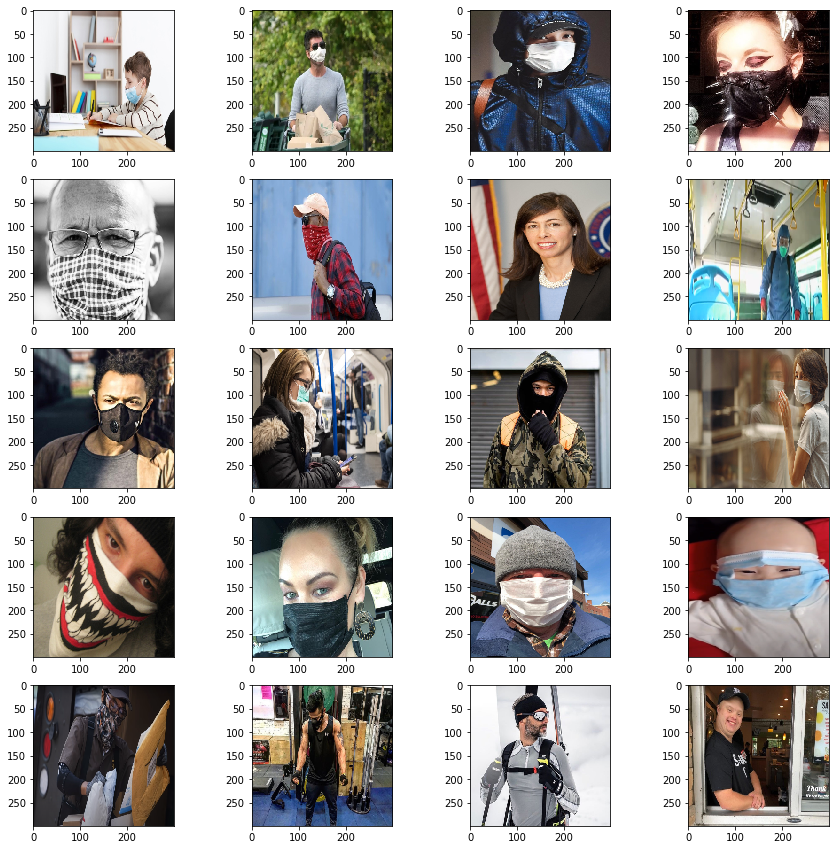

In [33]:
fig = plt.figure(figsize=[13,8])
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(0,20):
    num = np.random.randint(0,len(data))
    fig.add_subplot(5, 4, i+1)
    plt.imshow(data[num])
plt.show()

In [12]:
processing_data = (2*data.astype('float32')-255)/255
processing_label = label.copy()
processing_label[:,1:] = (2*processing_label[:,1:])/300

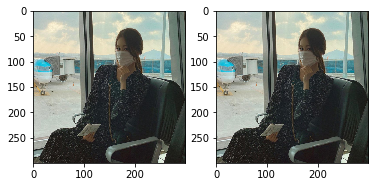

In [13]:
plt.subplot(1,2,1)
plt.imshow(((255*processing_data[100]+255)/2).astype("int32"))
plt.subplot(1,2,2)
plt.imshow(data[100])

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras import Model, Input
from tensorflow.keras import layers, models

In [15]:
IMAGE_SIZE = 300

In [16]:
inception = InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

In [17]:
inception_data = inception.predict(processing_data,batch_size=40,verbose=1)

2969/2969 [==============================] - 138s 46ms/sample


In [18]:
xTrain = inception_data[:2500]
yTrain = processing_label[:2500]
xValid = inception_data[2500:]
yValid = processing_label[2500:]

In [19]:
import tensorflow.keras.backend as K

In [20]:
def activation(x):
    return 1 + K.tanh(x)

In [21]:
def create_model(trainable=False):
    input_image = Input(shape=(8,8,2048))
    layer1 = layers.Conv2D(1,(8,8))(input_image)
    layer1 = layers.Activation('sigmoid')(layer1)
    layer1 = layers.Flatten()(layer1)
    
    layer2 = layers.Conv2D(4,(8,8))(input_image)
    layer2 = layers.Activation(activation)(layer2)
    layer2 = layers.Flatten()(layer2)
    
    result_layer = layers.Concatenate()([layer1,layer2])
    
    model = Model(inputs = input_image,outputs=result_layer)
    return model 

In [22]:
model = create_model()

In [23]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])

In [24]:
epochs = 40

In [25]:
xTrain[0].shape

(8, 8, 2048)

In [26]:
model_history = model.fit(
    x=xTrain,y=yTrain,
    epochs= epochs,
    batch_size=50,
    steps_per_epoch=50,
    validation_data=(xValid,yValid),
    validation_steps= 9
)

Train on 2500 samples, validate on 469 samples
Epoch 1/40
2500/2500 [==============================] - 2s 830us/sample - loss: 0.3778 - mae: 0.4506 - val_loss: 0.3490 - val_mae: 0.4405
Epoch 2/40
2500/2500 [==============================] - 2s 654us/sample - loss: 0.3681 - mae: 0.4438 - val_loss: 0.3490 - val_mae: 0.4405
Epoch 3/40
2500/2500 [==============================] - 2s 635us/sample - loss: 0.3681 - mae: 0.4438 - val_loss: 0.3490 - val_mae: 0.4405
Epoch 4/40
2500/2500 [==============================] - 2s 626us/sample - loss: 0.3681 - mae: 0.4438 - val_loss: 0.3490 - val_mae: 0.4405
Epoch 5/40
2500/2500 [==============================] - 2s 625us/sample - loss: 0.3681 - mae: 0.4438 - val_loss: 0.3490 - val_mae: 0.4405
Epoch 6/40
2500/2500 [==============================] - 2s 627us/sample - loss: 0.3681 - mae: 0.4438 - val_loss: 0.3490 - val_mae: 0.4405
Epoch 7/40
2500/2500 [==============================] - 2s 629us/sample - loss: 0.3681 - mae: 0.4438 - val_loss: 0.3490 - val

In [37]:
a = model.predict(xTrain[:200])

In [38]:
a

array([[1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0., 0., 2., 2.],
       [1., 0.

In [416]:
a = np.arange(-50,50)
b = np.tanh(a)+1

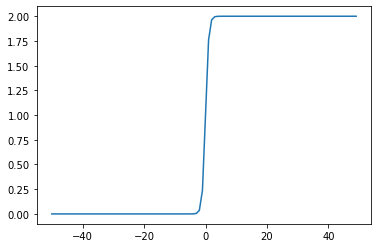

In [417]:
plt.plot(a,b)

In [405]:
np.unique(xTrain[10])

array([0.0000000e+00, 1.3045967e-05, 1.3187528e-05, ..., 1.3058352e+01,
       1.3252508e+01, 1.7749056e+01], dtype=float32)

In [370]:
yValid[3]

array([1.        , 0.35611038, 0.01731602, 0.77529566, 0.83549784])